# effective Equation of State in 3D (Figure 10 of Jeffreson+ 2024)

In [50]:
import numpy as np
from scipy import stats
import pickle
from pathlib import Path
import glob, os, re, sys
sys.path.append('../')

import configparser
config = configparser.ConfigParser()
config.read('../config/config_pressures-SFRs.ini')

from PRFMData import PRFMDataset
import astro_helper as ah
from astropy.io import ascii as asciitable
from astropy.table import Table
import density_contours

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as patches
from matplotlib import rc
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
rc('axes', linewidth=1.5)
rc('axes', edgecolor='#3C3C3C')
plt.style.use('mpl_style_Jeffreson.mplstyle')

In [51]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          r"Milky Way-like",
          r"NGC~300-like",]
colors = [plt.cm.magma((i+1)/5) for i in range(4)]
colors.append('#3C3C3C')
colors.append('#5E9F87')

In [52]:
tags = ['ETG-vlM', 'ETG-lowM', 'ETG-medM', 'ETG-hiM', 'MW', 'NGC300']
Rmaxs_kpc = [config[tag].getfloat('RMAX') for tag in tags]
Rmaxs_kpc = [1.5 if elem==2. else elem for elem in Rmaxs_kpc] # cut to actual max size of ETGs

In [53]:
def fitPlaneLTSQ(XYZ):
    (rows, cols) = XYZ.shape
    G = np.ones((rows, 3))
    G[:, 0] = XYZ[:, 0]  # X
    G[:, 1] = XYZ[:, 1]  # Y
    Z = XYZ[:, 2]
    (a, b, c),resid,rank,s = np.linalg.lstsq(G, Z)
    normal = (a, b, -1)
    nn = np.linalg.norm(normal)
    normal = normal / nn
    print(a,b,c)
    return (c, normal)

# simulation data

In [38]:
Rbin_centers, data_densities, data_PSFRs = [], [], []
for tag in tags:
    filesavedir = Path(config[tag]['ROOT_DIR']) / config[tag]['SUBDIR']

    # weight from this array (temperature threshold here has no impact)
    filesavename = min(glob.glob(str(filesavedir / "Figs-10-11_*_T2.0e+04_avir2.0e+00.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_densities.append(props_3D)

    # pressures, counts and SFRs from this array (respond to temperature threshold)
    filesavename = min(glob.glob(str(filesavedir / "pressures-SFRs-fixed-mp_*_T2.0e+04_avir2.0e+00.pkl")))
    with open(filesavename, "rb") as f:
        props_3D = pickle.load(f)
    data_PSFRs.append(props_3D)
    
    # radial bin data from this array
    filesavename = min(glob.glob(str(filesavedir / "Rbin_centers_*.pkl")))
    with open(filesavename, "rb") as f:
        Rbins = pickle.load(f)
    Rbin_centers.append(Rbins)

In [39]:
# fraction of points to take, to fit planes/lines with equal weighting for each galaxy
min_pts = min([len(elem) for elem in Rbin_centers])
divfacs = [int(np.rint(float(len(elem))/float(min_pts))) for elem in Rbin_centers]
print(divfacs)

[1, 1, 1, 1, 8, 4]


In [40]:
# calculate medians and quantiles
THRESHOLD = 100 # on the number of gas cells per voxel at the mid-plane
# this is particularly important for the SigmaSFR, because SFR is stochastic in this simulation, and
# values do not make sense if averages/medians are taken over too few cells

meddata, q1data, q4data = [], [], []
meddata_PSFRs, q1data_PSFRs, q4data_PSFRs = [], [], []
for i, Rmax_kpc, data_, data_PSFRs_ in zip(range(len(data_densities)), Rmaxs_kpc, data_densities, data_PSFRs):

    # take cuts to deal with stochasticity of the SFR, and to ensure the mid-plane
    # turbulent velocity dispersion is well-resolved
    cnd = (data_PSFRs_['midplane-count'] > THRESHOLD)
    for key, value in data_PSFRs_.items():
        value[~cnd] = np.nan
    for key, value in data_.items():
        if key == 'Kappa':
            continue
        value[~cnd] = np.nan

    # apply radial cut to disk extent for the ETGs
    cnd = (Rbin_centers[i]/ah.kpc_to_cm < Rmax_kpc)
    Rbin_centers[i] = Rbin_centers[i][cnd]
    meddata.append({key: np.nanmedian(value, axis=(1,2))[cnd] if key != 'Kappa' else np.nanmedian(value, axis=1)[cnd] for key, value in data_.items()})
    q1data.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] if key != 'Kappa' else np.nanquantile(value, 0.25, axis=1)[cnd] for key, value in data_.items()})
    q4data.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] if key != 'Kappa' else np.nanquantile(value, 0.75, axis=1)[cnd] for key, value in data_.items()})

    meddata_PSFRs.append({key: np.nanmedian(value, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q1data_PSFRs.append({key: np.nanquantile(value, 0.25, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})
    q4data_PSFRs.append({key: np.nanquantile(value, 0.75, axis=(1,2))[cnd] for key, value in data_PSFRs_.items()})

# 3D figure

/tmp/ipykernel_588512/510379195.py:38: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax0.dist = 12
/tmp/ipykernel_588512/510379195.py:39: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 12
/tmp/ipykernel_588512/510379195.py:40: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax2.dist = 12
/tmp/ipykernel_588512/2824081494.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (a, b, c),resid,rank,s = np.linalg.lstsq(G, Z)


-0.8266990798615983 1.6460207303051124 2.8474197439377567
-0.8266990798615983 1.6460207303051126 2.8474197439377567
slope = 1.1523442296148585 intercept = 3.9688003822747473


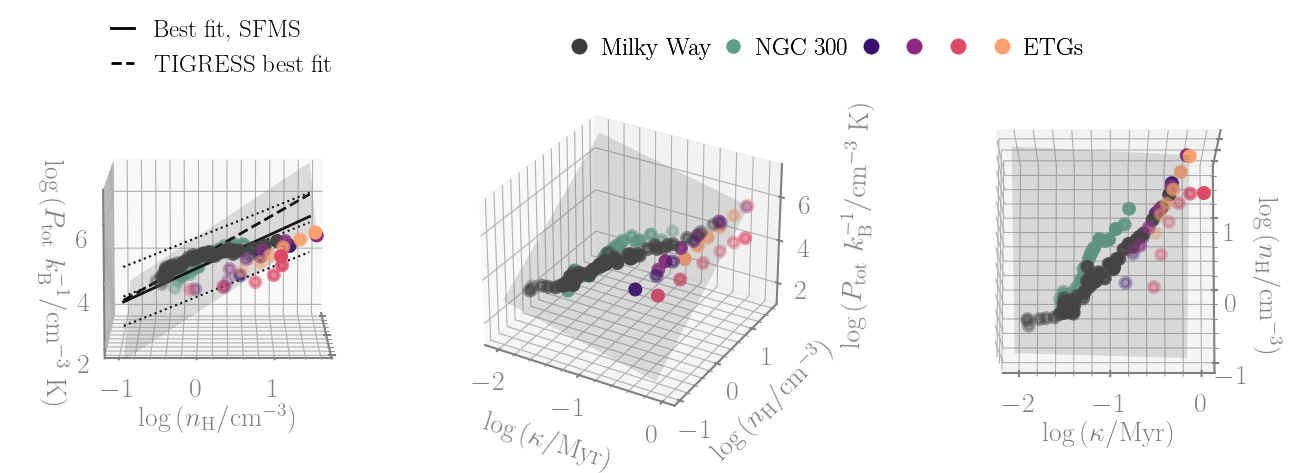

In [68]:
figW = 16
figH = 5
fig = plt.figure(figsize=(figW, figH))

topMarg = 0.1
leftMarg = 0.1
botMarg = 0.1
rightMarg = 0.1

wBetMarg = 0.02
hBetMarg = 0.01

crightMarg = 0.105
cW = 0.04
cBet = 0.02

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg-2*wBetMarg)/3

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, 2*h], projection='3d',
                    xticklabels='', zlim=[1.8, 7.])
ax1 = fig.add_axes([leftMarg+w+0.3*wBetMarg, botMarg, w, 2*h], projection='3d')
ax2 = fig.add_axes([leftMarg+2.*w+2.5*wBetMarg, botMarg, w, 2*h], projection='3d',
                    xlabel=r'$\log{(\kappa/{\rm Myr})}$',
                    ylabel=r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$',
                    zticklabels='')
ax2.view_init(80,-90)
ax0.view_init(10,0)
axs = [ax0, ax1, ax2]
ax0.set_ylabel(r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$', labelpad=20)
ax0.set_zlabel(r'$\log{(P_{\rm tot}~k_{\rm B}^{-1}/{\rm cm}^{-3}~{\rm K})}$')
ax1.set_xlabel(r'$\log{(\kappa/{\rm Myr})}$', labelpad=20)
ax1.set_ylabel(r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$', labelpad=15)
ax1.set_zlabel(r'$\log{(P_{\rm tot}~k_{\rm B}^{-1}/{\rm cm}^{-3}~{\rm K})}$', labelpad=20)
ax2.set_xlabel(r'$\log{(\kappa/{\rm Myr})}$', labelpad=20)
ax2.set_ylabel(r'$\log{(n_{\rm H}/{\rm cm}^{-3})}$', labelpad=20)
ax0.dist = 12
ax1.dist = 12
ax2.dist = 12

for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                which = 'both', direction='in')
    ax.minorticks_on()

Ptots, rhomps, kappas = [], [], []
SFMS_Ptots, SFMS_rhomps, SFMS_kappas = [], [], []
for ax in axs:
    for color, i, divfac in zip(colors, range(len(Rbin_centers)), divfacs):
        ax.scatter3D(np.log10(meddata[i]['Kappa']), np.log10(meddata[i]['midplane-dens']/ah.mp_cgs),
                     np.log10(meddata_PSFRs[i]['Ptot']), s=50, lw=3, color=color, zorder=3)
        if(i!=2): # not the quenched galaxy
            Ptots += list(meddata_PSFRs[i]['Ptot'][::divfac])
            rhomps += list(meddata[i]['midplane-dens'][::divfac])
            kappas += list(meddata[i]['Kappa'][::divfac])
        if(i>3):
            SFMS_Ptots += list(meddata_PSFRs[i]['Ptot'][::divfac])
            SFMS_rhomps += list(meddata[i]['midplane-dens'][::divfac])
            SFMS_kappas += list(meddata[i]['Kappa'][::divfac])

xpts, ypts, zpts = np.log10(np.array(kappas)), np.log10(np.array(rhomps)/ah.mp_cgs), np.log10(np.array(Ptots))
cnd = ~np.isnan(xpts) & ~np.isnan(ypts) & ~np.isnan(zpts)
xpts, ypts, zpts = xpts[cnd], ypts[cnd], zpts[cnd]
data = np.array([xpts, ypts, zpts]).T
c, normal = fitPlaneLTSQ(data)

# plot fitted plane
maxx = np.max(data[:,0])#+0.5
maxy = np.max(data[:,1])#+0.5
minx = np.min(data[:,0])-0.5
miny = np.min(data[:,1])-0.5

point = np.array([0.0, 0.0, c])
d = -point.dot(normal)

# compute points needed for plane plotting
xx, yy = np.meshgrid([minx, maxx], [miny, maxy])
z = (-normal[0]*xx - normal[1]*yy - d)*1. / normal[2]
print(-normal[0]/normal[2], -normal[1]/normal[2], -d/normal[2])

# plot plane
ax0.plot_surface(xx, yy, z, alpha=0.2, color='grey')
ax1.plot_surface(xx, yy, z, alpha=0.2, color='grey')
ax2.plot_surface(xx, yy, z, alpha=0.2, color='grey')

# fit line to SFMS points
slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.log10(np.array(SFMS_rhomps)/ah.mp_cgs),
    np.log10(np.array(SFMS_Ptots))
)
print("slope = "+str(slope), "intercept = "+str(intercept))

# # eEoS from TIGRESS
logxT = np.linspace(-1., 1.5, 30)
logyT = 1.43*logxT + 4.3
ax0.plot3D(-1.*np.ones(len(logxT)), logxT,  logyT, lw=2, color='black', ls='--', zorder=3)
ax0.plot3D(-1.*np.ones(len(logxT)), logxT,  slope*logxT+intercept, lw=2, color='black', zorder=3)

# isotherms
for logT in np.linspace(3,5,3):
       logyt = logT + logxT
       ax0.plot3D(-1.*np.ones(len(logxT)), logxT, logyt, zorder=0, color='k', ls='dotted')

# legend, sims
custom_lines = [Line2D([0], [0], marker='o', markerfacecolor='#3C3C3C',
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor='#5E9F87', markeredgewidth=2,
                       markeredgecolor='white', markersize=12.5, lw=3),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(1./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(2./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(3./5.),
                       markeredgecolor='white', markersize=12.5, lw=0),
                Line2D([0], [0], marker='o', markerfacecolor=plt.cm.magma(4./5.),
                       markeredgecolor='white', markersize=12.5, lw=0)]
legend1 = ax1.legend(
    custom_lines, [r'Milky Way', r'NGC~300', r'', r'', r'', r'ETGs'], loc='lower center', bbox_to_anchor=(1., 0.94),
    ncol=6, frameon=False, handlelength=0.2, columnspacing=0.75, fontsize=18
)
ax1.add_artist(legend1)

custom_lines = [Line2D([0], [0], color='k', lw=2),
                Line2D([0], [0], color='k', lw=2, ls='--')]
legend2 = ax0.legend(
    custom_lines, ['Best fit, SFMS', 'TIGRESS best fit'], bbox_to_anchor=(0.85, 1.15),
    ncol=1, frameon=False, handlelength=0.9, columnspacing=0.75, fontsize=18
)

plt.savefig('/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/eEoS_3D.pdf', bbox_inches='tight', format='pdf')
plt.show()